In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
base_path = Path("../eval_results/")

In [3]:
sns.__version__

'0.11.2'

In [20]:
results = pd.DataFrame()
runs = [x for x in os.listdir(base_path) if not os.path.isfile(x)]

main_methods = [    "effens",
                    "ml2dac",
                "effens (DBCV)",
                "effens (COP)",
                "aml4c (COP)",
                "aml4c (DBCV)",
               "AS-HPO (statistical+general) - DBCV",
               "AS-HPO (statistical+general) - COP",
                              "AS-HPO (autoclust) - MLP"]

method_name_mapping = {"effens": "EffEns+CVI-S",
                      "ml2dac": "ML2DAC", 
                       "effens (DBCV)": "EffEns (DBCV)",
                      "effens (COP)": "EffEns (COP)",
                      "aml4c (DBCV)": "AML4C (DBCV)",
                      "aml4c (COP)": "AML4C (COP)",
                       "AS-HPO (statistical+general) - DBCV": "AS->HPO (DBCV)",
                       "AS-HPO (statistical+general) - COP": "AS->HPO (COP)",
                       "AS-HPO (autoclust) - MLP": "AutoClust"
                                            }

for run in runs:
    run_int = int(run.split("_")[-1])
    if run_int > 2:
        continue
    approaches = [x for x in os.listdir(base_path / run) if not os.path.isfile(x)]
    for approach in approaches:
        if approach not in main_methods:
            continue
        datasets = os.listdir(base_path / run / approach)
        for dataset in datasets:
            df = pd.read_csv(base_path / run/approach / dataset)
            df["Method"] = method_name_mapping[approach]
            df["dataset"] = dataset
            df["run"] = int(run.split("_")[-1])
            if "_" in dataset:
                df["n"] = int(dataset.split("_")[-3].replace("n", ""))
            
            if len(df["CVI score"].unique()) == 1 or set(df["CVI score"].values) == set([-2, 2147483647]):
                print(f"Got only one CVI score for {approach} on {dataset}")
                df["NMI"] = 0
                df["Best NMI"] = 0
                df["ARI"] = 0
                df["Best ARI"] = 0
            
            max_iter = df["iteration"].max()
            act_max_iter = min(df["iteration"].max(), 70)
            df["act_max_iter"] = min(act_max_iter, 70)
            while max_iter < 70:
                max_iter += 1
                new_df = pd.DataFrame(df[-1:].values, columns=df.columns)
                new_df["iteration"] = max_iter
                df = df.append(new_df)
            df["runtime per config"] = df["wallclock time"].max() / act_max_iter
            #if "ml2dac" in approach:                
            results = pd.concat([results, df])
results["Best ARI"] = pd.to_numeric(results["Best ARI"]) * -1 * 100
results["Best NMI"] = pd.to_numeric(results["Best NMI"]) * -1 * 100
results["ARI"] = pd.to_numeric(results["ARI"]) * -1 * 100
results["NMI"] = pd.to_numeric(results["NMI"]) * -1 * 100
results["Best CVI score"] = pd.to_numeric(results["Best CVI score"])
results["wallclock time"] = pd.to_numeric(results["wallclock time"])
results["act_max_iter"] = pd.to_numeric(results["act_max_iter"])

results["Method"] = pd.Categorical(results["Method"], method_name_mapping.values(), ordered=True)

results = results.sort_values("Method")
fmnist_data_not_ready = [f"Fashion-MNIST_n{i}0000_f784_c10.csv" for i in range(3, 7)] #?
all_fmnist_data = [f"Fashion-MNIST_n{i}0000_f784_c10.csv" for i in range(1,8)]
all_except_largest_fmnist_data = [f"Fashion-MNIST_n{i}0000_f784_c10.csv" for i in range(1,7)]

bad_data = ["haberman.csv", "german.csv", 
            "balance-scale.csv",
            "arrhythmia.csv", 
            "heart-statlog.csv", 
            "sonar.csv", 
            "tae.csv", 
           # "vehicle.csv"
           ]
mnist_data = [f"mnist_784_n{i}0000_f784_c10.csv" for i in range(1, 8)]
new_added_data = mnist_data.copy()
new_added_data.append("miceprotein_n1080_f77_c8.csv")
new_added_data.append("har_n10299_f561_c6.csv")


results["max NMI"] = results.groupby(["Method", "dataset", "run"])["Best NMI"].transform(min)
max_nmi_results = results[results["Best NMI"] == results["max NMI"]]
results["max iteration"] = results.groupby(["Method", "dataset", "run"])["iteration"].transform(max)
max_iter_results = results[results["iteration"] == results["max iteration"]]

Got only one CVI score for aml4c (DBCV) on Fashion-MNIST_n20000_f784_c10.csv
Got only one CVI score for aml4c (DBCV) on Fashion-MNIST_n30000_f784_c10.csv
Got only one CVI score for aml4c (DBCV) on Fashion-MNIST_n40000_f784_c10.csv
Got only one CVI score for aml4c (DBCV) on Fashion-MNIST_n50000_f784_c10.csv
Got only one CVI score for aml4c (DBCV) on Fashion-MNIST_n60000_f784_c10.csv
Got only one CVI score for aml4c (DBCV) on Fashion-MNIST_n70000_f784_c10.csv
Got only one CVI score for aml4c (DBCV) on mnist_784_n20000_f784_c10.csv
Got only one CVI score for aml4c (DBCV) on mnist_784_n30000_f784_c10.csv
Got only one CVI score for aml4c (DBCV) on mnist_784_n40000_f784_c10.csv
Got only one CVI score for aml4c (DBCV) on mnist_784_n50000_f784_c10.csv
Got only one CVI score for aml4c (DBCV) on mnist_784_n60000_f784_c10.csv
Got only one CVI score for aml4c (DBCV) on mnist_784_n70000_f784_c10.csv
Got only one CVI score for AS-HPO (statistical+general) - COP on thy.csv
Got only one CVI score for 

<AxesSubplot:xlabel='iteration', ylabel='Best NMI'>

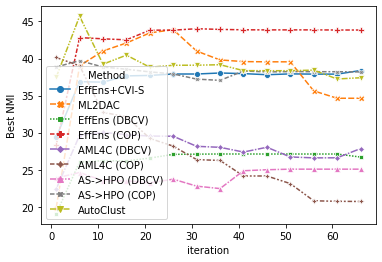

In [9]:
plot_data = results[(results["run"].isin([0]))
                    &(results["iteration"].isin(list(range(1, 71, 5))))
                     &(~results["dataset"].isin(bad_data))
                          #& (results["Method"].isin(["ml2dac", "effens"]))
                         #& (results["dataset"]=="zoo.csv")
                   ]
plot_data = plot_data.reset_index()
sns.lineplot(data=plot_data, 
             hue="Method",
             style="Method",
             markers=True,
             #markevery=5,
             x="iteration", 
             y="Best NMI", 
             ci=None)

In [171]:
max_iter_results[(max_iter_results["run"] == 0) 
                 &(max_iter_results["Method"] == "ml2dac")
                ].groupby(["dataset"])["Best ARI"].mean()

for data in bad_data:
    print(max_iter_results[max_iter_results["dataset"]== data].groupby(["Method"])["Best ARI"].mean())

Method
effens          -0.061013
effens (DBCV)    2.049007
effens (COP)     0.318201
ml2dac           1.157705
aml4c (COP)      0.293566
aml4c (DBCV)     0.328025
Name: Best ARI, dtype: float64
Method
effens           5.391954
effens (DBCV)    0.117294
effens (COP)     0.128668
ml2dac          -0.068409
aml4c (COP)     -0.166834
aml4c (DBCV)     0.066803
Name: Best ARI, dtype: float64
Method
effens           9.274715
effens (DBCV)    2.232550
effens (COP)     1.690179
ml2dac           1.984261
aml4c (COP)      1.498086
aml4c (DBCV)     1.685327
Name: Best ARI, dtype: float64
Method
effens           3.814704
effens (DBCV)    6.866593
effens (COP)     1.867717
ml2dac           5.116133
aml4c (COP)      0.388591
aml4c (DBCV)     0.828463
Name: Best ARI, dtype: float64
Method
effens           2.544373
effens (DBCV)    3.590254
effens (COP)     0.446231
ml2dac           5.921775
aml4c (COP)      5.182858
aml4c (DBCV)     6.144892
Name: Best ARI, dtype: float64
Method
effens           3.1539

In [36]:
all_mnist_data = [f"Fashion-MNIST_n{i}0000_f784_c10.csv" for i in range(1,8)]
max_iter_results[(max_iter_results["Method"] == "ml2dac")
                 & (max_iter_results["dataset"].isin(all_mnist_data))
                ][["run", "dataset", "Method", "cvi", "Best NMI", "best config"]]

,run,dataset,Method,cvi,Best NMI,best config
99,0,Fashion-MNIST_n10000_f784_c10.csv,ml2dac,CH,-0.183068,"{'algorithm': 'KMeans', 'n_clusters': 2}"
77,0,Fashion-MNIST_n20000_f784_c10.csv,ml2dac,CH,-0.189516,"{'algorithm': 'KMeans', 'n_clusters': 2}"
0,0,Fashion-MNIST_n30000_f784_c10.csv,ml2dac,CH,-0.148680,"{'algorithm': 'MBKMeans', 'n_clusters': 2}"
0,0,Fashion-MNIST_n40000_f784_c10.csv,ml2dac,CH,-0.539621,"{'algorithm': 'MBKMeans', 'n_clusters': 9}"
0,0,Fashion-MNIST_n50000_f784_c10.csv,ml2dac,CH,-0.486644,"{'algorithm': 'MBKMeans', 'n_clusters': 10}"
0,0,Fashion-MNIST_n60000_f784_c10.csv,ml2dac,CH,-0.499249,"{'algorithm': 'MBKMeans', 'n_clusters': 10}"
0,0,Fashion-MNIST_n70000_f784_c10.csv,ml2dac,CH,-0.533999,"{'algorithm': 'MBKMeans', 'n_clusters': 10}"


In [53]:
all_mnist_data = [f"Fashion-MNIST_n{i}0000_f784_c10.csv" for i in range(1,8)]
max_iter_results[(max_iter_results["Method"] == "effens")
                 & (max_iter_results["dataset"].isin(mnist_data))
                ][["run", "dataset", "Method", "cvi", "Best NMI", "best config"]]

,run,dataset,Method,cvi,Best NMI,best config
69,0,mnist_784_n10000_f784_c10.csv,effens,SIL,-0.208881,"{'cc_function': 'ACV', 'k': 2, 'm': 2}"
69,0,mnist_784_n20000_f784_c10.csv,effens,SIL,-0.218401,"{'cc_function': 'ACV', 'k': 2, 'm': 2}"
69,0,mnist_784_n30000_f784_c10.csv,effens,SIL,-0.192907,"{'cc_function': 'ACV', 'k': 2, 'm': 2}"
69,0,mnist_784_n40000_f784_c10.csv,effens,SIL,-0.532090,"{'cc_function': 'ACV', 'k': 100, 'm': 2}"
69,0,mnist_784_n50000_f784_c10.csv,effens,SIL,-0.143059,"{'cc_function': 'ACV', 'k': 2, 'm': 2}"
69,0,mnist_784_n60000_f784_c10.csv,effens,SIL,-0.193889,"{'cc_function': 'ACV', 'k': 2, 'm': 2}"
69,0,mnist_784_n70000_f784_c10.csv,effens,SIL,-0.194269,"{'cc_function': 'ACV', 'k': 2, 'm': 2}"


In [20]:
results[(results["iteration"] == 70) 
        & (results["dataset"].isin(all_fmnist_data))].groupby(["dataset", 
                                                               "Method"])["wallclock time", "act_max_iter", "runtime per config"].mean().head(20)

<ipython-input-20-ae9512fb9a1e>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  results[(results["iteration"] == 70)


wallclock time  \
dataset                           Method                           
Fashion-MNIST_n10000_f784_c10.csv EffEns+CVI-S        235.325808   
                                  ML2DAC             1493.817136   
                                  EffEns (DBCV)       400.702732   
                                  EffEns (COP)        339.079025   
                                  AML4C (DBCV)       2101.629105   
                                  AML4C (COP)        3346.688141   
                                  AS->HPO (DBCV)     1558.284091   
                                  AS->HPO (COP)      1509.050296   
                                  AutoClust           789.252977   
Fashion-MNIST_n20000_f784_c10.csv EffEns+CVI-S        514.954900   
                                  ML2DAC             6802.642973   
                                  EffEns (DBCV)      1029.066474   
                                  EffEns (COP)        746.642016   
                                  AML4C (DBCV)       7151.616251   
                                  AML4C (COP)        7329.375249   
                                  AS->HPO (DBCV)     6398.031569   
                                  AS->HPO (COP)      6111.916830   
                                  AutoClust          4437.386874   
Fashion-MNIST_n30000_f784_c10.csv EffEns+CVI-S        988.232729   
                                  ML2DAC             7388.494364   

                                                  act_max_iter  \
dataset                           Method                         
Fashion-MNIST_n10000_f784_c10.csv EffEns+CVI-S            70.0   
                                  ML2DAC                  70.0   
                                  EffEns (DBCV)           70.0   
                                  EffEns (COP)            70.0   
                                  AML4C (DBCV)            70.0   
                                  AML4C (COP)             70.0   
                                  AS->HPO (DBCV)          70.0   
                                  AS->HPO (COP)           70.0   
                                  AutoClust               70.0   
Fashion-MNIST_n20000_f784_c10.csv EffEns+CVI-S            70.0   
                                  ML2DAC                  62.5   
                                  EffEns (DBCV)           70.0   
                                  EffEns (COP)            70.0   
                                  AML4C (DBCV)            63.0   
                                  AML4C (COP)             36.5   
                                  AS->HPO (DBCV)          70.0   
                                  AS->HPO (COP)           70.0   
                                  AutoClust               70.0   
Fashion-MNIST_n30000_f784_c10.csv EffEns+CVI-S            70.0   
                                  ML2DAC                  32.5   

                                                  runtime per config  
dataset                           Method                              
Fashion-MNIST_n10000_f784_c10.csv EffEns+CVI-S              3.361797  
                                  ML2DAC                   32.559894  
                                  EffEns (DBCV)             5.724325  
                                  EffEns (COP)              4.843986  
                                  AML4C (DBCV)             61.430585  
                                  AML4C (COP)              81.802003  
                                  AS->HPO (DBCV)           22.261201  
                                  AS->HPO (COP)            22.261201  
                                  AutoClust                11.275043  
Fashion-MNIST_n20000_f784_c10.csv EffEns+CVI-S              7.356499  
                                  ML2DAC                  117.923722  
                                  EffEns (DBCV)            14.700950  
                                  EffEns (COP)             10.666315  
                                  A

In [151]:
max_iter_results[max_iter_results["Method"] == "ml2dac"]["wallclock time"].mean() / max_iter_results[max_iter_results["Method"] == "ml2dac"]["act_max_iter"].mean() 

32.5687176625083

In [26]:
main_methods = ["effens",
                "ml2dac",
                "aml4c (COP)",
                "aml4c (DBCV)", 
                "effens (DBCV)",
                "effens (COP)"]
table_results = results[(~results["dataset"].isin(bad_data)) &
        (results["iteration"] == 70)
        & (~results["dataset"].isin(mnist_data))
        &(~results["dataset"].isin(all_except_largest_fmnist_data))
        #& (results["Method"].isin(main_methods))
        #& (~results["dataset"].isin(fmnist_data_not_ready))
]
table_results.groupby([#"run",
                       "Method"])[["Best ARI", "Best NMI", 
                                   "wallclock time", "runtime per config", 
                                   "act_max_iter"]].mean().round(1)

,Best ARI,Best NMI,wallclock time,runtime per config,act_max_iter
Method,,,,,
EffEns+CVI-S,31.9,45.4,208.8,3.0,70.0
ML2DAC,27.9,38.8,384.8,46.4,67.8
EffEns (DBCV),25.3,42.7,437.7,9.3,68.7
EffEns (COP),21.3,41.1,281.4,4.0,70.0
AML4C (DBCV),19.9,40.4,755.5,30.3,67.5
AML4C (COP),9.2,20.8,834.3,47.3,67.2
AS->HPO (DBCV),18.0,32.7,855.0,57.3,67.3
AS->HPO (COP),18.1,34.3,329.0,17.4,69.2
AutoClust,25.9,41.7,1368.4,91.0,68.5


In [23]:
table_results.iloc[table_results.groupby(["Method"])["Best ARI"].idxmin()]

,runtime,iteration,config,dataset,mf time,similar dataset,cvi,algorithms,Method,CVI score,...,cf,gen_time,gen_ari,gen_nmi,gen_cvi,m,rs,gen_error,max NMI,max iteration
69,0.032244,70,"{'algorithm': 'KMeans', 'n_clusters': 84}",iono.csv,0.051265,type=varied-k=10-n=1000-d=50-noise=0,DBCV,MBKMeans+GMM+KMeans+birch+dbscan+ward,ML2DAC,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.515498,100
69,0.032244,70,"{'algorithm': 'KMeans', 'n_clusters': 84}",iono.csv,0.051265,type=varied-k=10-n=1000-d=50-noise=0,DBCV,MBKMeans+GMM+KMeans+birch+dbscan+ward,ML2DAC,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.515498,100
69,0.08659,70,"{'cc_function': 'ACV', 'k': 72, 'm': 10}",glass.csv,NaN,NaN,DBCV,NaN,EffEns+CVI-S,1.0,...,ACV,0.752501,-0.037111,-0.110687,0.61173,10,1234,NaN,18.398728,70
69,0.032244,70,"{'algorithm': 'KMeans', 'n_clusters': 84}",iono.csv,0.051265,type=varied-k=10-n=1000-d=50-noise=0,DBCV,MBKMeans+GMM+KMeans+birch+dbscan+ward,ML2DAC,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.515498,100
69,0.032244,70,"{'algorithm': 'KMeans', 'n_clusters': 84}",iono.csv,0.051265,type=varied-k=10-n=1000-d=50-noise=0,DBCV,MBKMeans+GMM+KMeans+birch+dbscan+ward,ML2DAC,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.515498,100
69,0.032244,70,"{'algorithm': 'KMeans', 'n_clusters': 84}",iono.csv,0.051265,type=varied-k=10-n=1000-d=50-noise=0,DBCV,MBKMeans+GMM+KMeans+birch+dbscan+ward,ML2DAC,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.515498,100
69,0.08659,70,"{'cc_function': 'ACV', 'k': 72, 'm': 10}",glass.csv,NaN,NaN,DBCV,NaN,EffEns+CVI-S,1.0,...,ACV,0.752501,-0.037111,-0.110687,0.61173,10,1234,NaN,18.398728,70
69,0.163969,70,"{'cc_function': 'ACV', 'k': 91, 'm': 7}",wdbc_n569_f31_k2.csv,NaN,NaN,DBCV,NaN,EffEns (DBCV),2147483647.0,...,ACV,0.809727,-0.23208,-0.341894,NaN,7,1234,NaN,29.719137,70
69,0.032244,70,"{'algorithm': 'KMeans', 'n_clusters': 84}",iono.csv,0.051265,type=varied-k=10-n=1000-d=50-noise=0,DBCV,MBKMeans+GMM+KMeans+birch+dbscan+ward,ML2DAC,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.515498,100


In [126]:
len(table_results["dataset"].unique())

22

In [44]:
results[(~results["dataset"].isin(bad_data)) &
        (results["iteration"] == 70)
        & (results["dataset"].isin(all_fmnist_data))
        & (results["Method"].isin(main_methods))
        #& (~results["dataset"].isin(fmnist_data_not_ready))
].groupby(["Method", "dataset"])["wallclock time"].mean()

Method         dataset                          
effens         Fashion-MNIST_n10000_f784_c10.csv     235.325808
               Fashion-MNIST_n20000_f784_c10.csv     514.954900
               Fashion-MNIST_n30000_f784_c10.csv     988.232729
               Fashion-MNIST_n40000_f784_c10.csv    1442.935557
               Fashion-MNIST_n50000_f784_c10.csv    1955.855752
               Fashion-MNIST_n60000_f784_c10.csv    2642.061026
               Fashion-MNIST_n70000_f784_c10.csv    3661.011543
effens (DBCV)  Fashion-MNIST_n10000_f784_c10.csv     424.908854
               Fashion-MNIST_n20000_f784_c10.csv    1029.066474
               Fashion-MNIST_n30000_f784_c10.csv    1435.798083
               Fashion-MNIST_n40000_f784_c10.csv    2952.447412
               Fashion-MNIST_n50000_f784_c10.csv    4008.661301
               Fashion-MNIST_n60000_f784_c10.csv    6345.506026
               Fashion-MNIST_n70000_f784_c10.csv    7105.297251
effens (COP)   Fashion-MNIST_n10000_f784_c10.csv     32

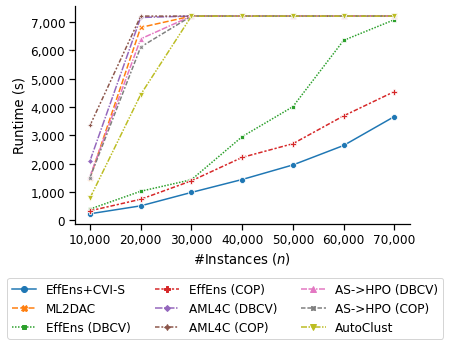

In [26]:
import matplotlib as mpl
plot_data_runtime = results[#~results["dataset"].isin(bad_data)) &
        (results["iteration"] == 70)
        & (results["dataset"].isin(all_fmnist_data))
        #& (results["Method"].isin(main_methods))
        #& (~results["dataset"].isin(fmnist_data_not_ready))
].reset_index()
plot_data_runtime["wallclock time"] = plot_data_runtime["wallclock time"].apply(lambda x: min(7200, x))
with sns.plotting_context("notebook",font_scale=1.1):

    ax = sns.lineplot(data=plot_data_runtime, 
                      x="n",
                      y="wallclock time",
                      hue="Method", 
                      style="Method", markers=True, ci=None, #label="big"
                     )
    h,l = ax.get_legend_handles_labels()

    #h.insert(0, plt.plot([], marker="", ls="")[0])
    #l.insert(0, " $\\bf{AML4C + CF}$")
    #h.insert(1, plt.plot([], marker="", ls="")[0])
    #l.insert(1, "")
    plt.legend(h,l, 
               bbox_to_anchor=(1.1, -0.25),
               loc=0,
               borderaxespad=0,
               ncol=3)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel("Runtime (s)")
    ax.set_xlabel(r"#Instances ($n$)")
    plt.ticklabel_format(style='scientific', axis='y')
    ax.get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax.get_xaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
#plt.savefig("Runtime_scalability_mnist.pdf", bbox_inches='tight')

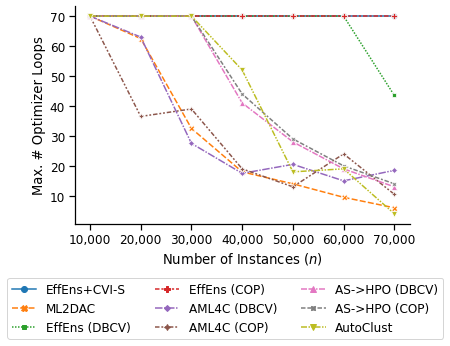

In [27]:
with sns.plotting_context("notebook",font_scale=1.1):

    ax = sns.lineplot(data=plot_data_runtime, 
                      x="n",
                      y="act_max_iter",
                      hue="Method", 
                      style="Method", markers=True, ci=None, #label="big"
                     )
    h,l = ax.get_legend_handles_labels()

    #h.insert(0, plt.plot([], marker="", ls="")[0])
    #l.insert(0, " $\\bf{AML4C + CF}$")
    #h.insert(1, plt.plot([], marker="", ls="")[0])
    #l.insert(1, "")
    plt.legend(h,l, 
               bbox_to_anchor=(1.1, -0.25),
               loc=0,
               borderaxespad=0,
               ncol=3)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel("Max. # Optimizer Loops")
    ax.set_xlabel(r"Number of Instances ($n$)")
    plt.ticklabel_format(style='scientific', axis='y')
    ax.get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax.get_xaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    
#plt.savefig("Max_iteration_mnist.pdf", bbox_inches='tight')

In [34]:
for dataset in table_results["dataset"].unique():
    print("---------------------------------------")
    print(table_results[(table_results["run"] == 0) 
                        & (table_results["dataset"] == dataset)].groupby(["dataset", "Method"])[["Best NMI", "Best ARI"]].mean().round(2))
    print("---------------------------------------")


---------------------------------------
                         Best NMI  Best ARI
dataset   Method                           
glass.csv effens            38.22     26.30
          effens (DBCV)     33.83     22.78
          effens (COP)      26.21     11.58
          ml2dac            35.31     23.35
          aml4c (COP)        1.56      0.81
          aml4c (DBCV)      36.68     24.13
---------------------------------------
---------------------------------------
                                                 Best NMI  Best ARI
dataset                           Method                           
Fashion-MNIST_n60000_f784_c10.csv effens            29.20     12.95
                                  effens (DBCV)      0.00      0.00
                                  effens (COP)      47.39     10.97
                                  ml2dac            49.92     34.59
                                  aml4c (COP)       49.02     12.68
                                  aml4c (DBCV)      

In [21]:
main_methods = ["effens",
                "ml2dac",
                "aml4c (COP)",
                "aml4c (DBCV)", 
                "effens (DBCV)",
                "effens (COP)"]
results[(~results["dataset"].isin(bad_data)) &
        (results["iteration"] == 70)
        & (~results["dataset"].isin(mnist_data))
        #&(~results["dataset"].isin(all_except_largest_fmnist_data))
        & (results["Method"].isin(main_methods))
        #& (~results["dataset"].isin(fmnist_data_not_ready))
].groupby(["run", "Method"])[["Best ARI", "Best NMI", "wallclock time", "runtime per config"]].mean().round(1).to_latex()

'\\begin{tabular}{llrrrr}\n\\toprule\n  &              &  Best ARI &  Best NMI &  wallclock time &  runtime per config \\\\\nrun & Method &           &           &                 &                     \\\\\n\\midrule\n0 & effens &      28.4 &      43.9 &           334.9 &                 4.8 \\\\\n  & effens (DBCV) &      21.0 &      35.6 &           947.0 &                16.7 \\\\\n  & effens (COP) &      19.6 &      43.4 &           665.9 &                 9.5 \\\\\n  & ml2dac &      27.9 &      39.7 &          1959.9 &               137.9 \\\\\n  & aml4c (COP) &       7.1 &      17.9 &          2231.9 &               101.0 \\\\\n  & aml4c (DBCV) &      18.8 &      34.2 &          2210.3 &               107.4 \\\\\n1 & effens &      27.0 &      41.5 &           700.7 &                10.0 \\\\\n  & effens (DBCV) &      22.3 &      37.1 &          1026.7 &                16.5 \\\\\n  & effens (COP) &      20.0 &      43.3 &           651.5 &                 9.3 \\\\\n  & ml2dac &   

In [105]:
results[(~results["dataset"].isin(bad_data)) &
        (results["iteration"] == 25)
        & (~results["dataset"].isin(mnist_data))
        &(~results["dataset"].isin(all_except_largest_fmnist_data))
        & (results["Method"].isin(main_methods))
        #& (~results["dataset"].isin(fmnist_data_not_ready))
]["dataset"].unique()

array(['banknote_n1372_f4_k2.csv', 'dermatology_n366_f33_k6.csv',
       'ecoli_n336_f8_k8.csv', 'Fashion-MNIST_n70000_f784_c10.csv',
       'glass.csv', 'har_n10299_f561_c6.csv', 'iono.csv',
       'iris_n150_f5_k3.csv', 'letter_n20000_f16_c26.csv',
       'miceprotein_n1080_f77_c8.csv', 'pendigits_n10992_f16_c10.csv',
       'segment.csv', 'thy.csv', 'USPS_n9298_f256_c10.csv', 'vowel.csv',
       'wdbc_n569_f31_k2.csv', 'wine.csv', 'wisc.csv', 'yeast.csv',
       'zoo.csv'], dtype=object)

In [30]:
max_iter_results[(max_iter_results["dataset"].isin(all_fmnist_data))
        & (max_iter_results["Method"].isin(["AutoClust"]))
        #& (~results["dataset"].isin(fmnist_data_not_ready))
].groupby(["dataset"])[["Best ARI", "Best NMI", "wallclock time", "runtime per config"]].mean().round(2)

,Best ARI,Best NMI,wallclock time,runtime per config
dataset,,,,
Fashion-MNIST_n10000_f784_c10.csv,8.92,18.31,789.25,11.28
Fashion-MNIST_n20000_f784_c10.csv,14.58,38.39,4437.39,63.39
Fashion-MNIST_n30000_f784_c10.csv,14.62,38.13,9926.35,141.81
Fashion-MNIST_n40000_f784_c10.csv,14.70,38.26,14388.69,276.71
Fashion-MNIST_n50000_f784_c10.csv,0.00,0.00,14483.29,804.63
Fashion-MNIST_n60000_f784_c10.csv,0.00,0.00,14933.79,785.99
Fashion-MNIST_n70000_f784_c10.csv,14.78,38.47,18427.05,4606.76


In [7]:
bad_data = ["haberman.csv", "german.csv", "balance-scale.csv", "arrhythmia.csv", 
            "heart-statlog.csv", 
            "sonar.csv", 
            "tae.csv", 
            "vehicle.csv"]

max_iter_results.groupby(["run", "Method"])[["Best NMI",
                                               "Best ARI", "wallclock time"]].median().round(2)

Best NMI  Best ARI  wallclock time
run Method                                           
0   effens            33.64     12.95           40.78
    effens (DBCV)     18.97      6.87           42.31
    effens (COP)      47.01     10.99           36.88
    ml2dac            24.59      8.92           22.10
    aml4c (COP)       10.13      1.31           29.26
    aml4c (DBCV)      17.10      2.07           59.83
1   effens            33.83     10.97           26.70
    effens (DBCV)     28.16      9.22           31.14
    effens (COP)      35.91     10.81           25.42
    ml2dac            22.38      6.26           14.63
    aml4c (COP)       11.36      2.04           13.38
    aml4c (DBCV)      21.51      3.96           29.34

In [22]:
max_iter_results[(~max_iter_results["dataset"].isin(bad_data)) 
                 & (max_iter_results["run"] ==2)
       ].groupby(["Method"])["Best NMI", "Best ARI", "wallclock time"].mean()

<ipython-input-22-578ada36c6a7>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  max_iter_results[(~max_iter_results["dataset"].isin(bad_data))


""
Method
aml4c (CH)
aml4c (SIL)
effens
effens (CH)
effens (SIL)
ml2dac
ml2dac (no warm)


In [28]:
results[results["Method"] == "effens"]["gen_nmi"].mean()

-0.2857683923224489

In [64]:
results[results["dataset"] == "Fashion-MNIST_n60000_f784_c10.csv"]["cvi"].unique()

array(['CH'], dtype=object)

In [54]:
max_iter_results[max_iter_results["dataset"] == "Fashion-MNIST_n60000_f784_c10.csv"].groupby(["dataset", "Method"])["Best NMI", "Best ARI", "wallclock time", "cvi"].mean()

<ipython-input-54-44ee758479f5>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  max_iter_results[max_iter_results["dataset"] == "Fashion-MNIST_n60000_f784_c10.csv"].groupby(["dataset", "Method"])["Best NMI", "Best ARI", "wallclock time", "cvi"].mean()


Best NMI  Best ARI  \
dataset                           Method                              
Fashion-MNIST_n60000_f784_c10.csv aml4c (COP)   -0.490234 -0.126841   
                                  aml4c (DBCV)   0.000000  0.000000   
                                  effens        -0.291986 -0.129539   
                                  effens (COP)  -0.473904 -0.109704   
                                  effens (DBCV)  0.000000  0.000000   
                                  ml2dac        -0.499249 -0.345895   

                                                 wallclock time  
dataset                           Method                         
Fashion-MNIST_n60000_f784_c10.csv aml4c (COP)       8246.555715  
                                  aml4c (DBCV)      7999.090551  
                                  effens            1332.444633  
                                  effens (COP)      3864.690828  
                                  effens (DBCV)     5727.061818  
                                  ml2dac            8422.891037

In [56]:
results[results["dataset"] == "Fashion-MNIST_n60000_f784_c10.csv"].groupby(["dataset", "Method"])["NMI", "Best ARI", "wallclock time", "cvi"].min()

<ipython-input-56-0e587f4ad833>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  results[results["dataset"] == "Fashion-MNIST_n60000_f784_c10.csv"].groupby(["dataset", "Method"])["NMI", "Best ARI", "wallclock time", "cvi"].min()


NMI  Best ARI  \
dataset                           Method                              
Fashion-MNIST_n60000_f784_c10.csv aml4c (COP)   -0.512612 -0.126841   
                                  aml4c (DBCV)   0.000000  0.000000   
                                  effens        -0.524389 -0.129539   
                                  effens (COP)  -0.555971 -0.247416   
                                  effens (DBCV)  0.000000  0.000000   
                                  ml2dac        -0.605796 -0.375092   

                                                 wallclock time   cvi  
dataset                           Method                               
Fashion-MNIST_n60000_f784_c10.csv aml4c (COP)         48.234360   COP  
                                  aml4c (DBCV)        65.533488  DBCV  
                                  effens              25.791902    CH  
                                  effens (COP)        56.069419   COP  
                                  effens (DBCV)      149.171849  DBCV  
                                  ml2dac             711.088890    CH